<a href="https://colab.research.google.com/github/NeelayS/ppe-detection/blob/main/processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/projects/ppe/

/content/drive/MyDrive/projects/ppe


# Imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, io
from os.path import join
import matplotlib.pyplot as plt

# Data

In [ ]:
class PictorPPEDataset(Dataset):
    def __init__(self, img_dir, annotations_list):
        super().__init__()

        self.img_dir = img_dir

        with open(annotations_list, "rb") as f:
            self.annotations = sorted(f.readlines())
        f.close()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):

        annotation = str(self.annotations[idx])[2:-5].split("\\t")

        img_name = annotation[0]
        img = io.read_image(join(self.img_dir, img_name))

        cropped_detections = []
        labels = []

        for det_annotation in annotation[1:]:

            label = int(det_annotation[-1])
            if label==2 or label==3:
              label=1
            labels.append(label)

            x1, y1, x2, y2 = list(map(lambda x: int(x), det_annotation[:-2].split(",")))
            cropped_detection = img[:, y1:y2, x1:x2].float()
            cropped_detections.append(cropped_detection)

        return cropped_detections, labels


In [ ]:
dataset = PictorPPEDataset("./Images", "Labels/pictor_ppe_crowdsourced_approach-02_train.txt")

In [ ]:
dataloader = DataLoader(dataset, batch_size=1)

In [ ]:
sample = next(iter(dataloader))
print(type(sample))

<class 'list'>


In [ ]:
l_0 = 0
l_1 = 0
l_2 = 0
l_3 = 0

for _, labels in dataloader:
  for label in labels:
    if label.item()==0:
      l_0 += 1
    elif label.item()==1:
      l_1 += 1
    elif label.item()==2:
      l_2 += 1
    else:
      l_3 += 1
    
print(l_0, l_1, l_2, l_3)

577 1069 0 0


In [ ]:
sample[1][0]

tensor([1])

In [ ]:
with open("Labels/pictor_ppe_crowdsourced_approach-02_train.txt", 'rb') as f:
  annotations = sorted(f.readlines())

In [ ]:
type(annotations)

list

In [ ]:
str(annotations[1])[2:-5].split("\\t")

['image_from_china(10).jpg',
 '143,165,202,277,0',
 '319,157,328,192,0',
 '343,158,355,188,0',
 '328,157,339,191,0']

In [ ]:
str(annotations[1])[2:-5].split("\\t")[1][:-2].split(",")

['143', '165', '202', '277']

In [ ]:
crop = sample[0][0]
crop.shape

torch.Size([1, 3, 145, 48])

In [ ]:
import matplotlib.pyplot as plt

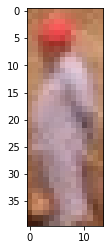

In [ ]:
crop = crop.squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(crop)

# Model Definition

In [ ]:
!pip install pytorchyolo

     |████████████████████████████████| 42 kB 829 kB/s 
     |████████████████████████████████| 948 kB 8.4 MB/s 
     |████████████████████████████████| 3.1 MB 28.6 MB/s 
     |████████████████████████████████| 11.2 MB 30.3 MB/s 
     |████████████████████████████████| 899 kB 47.6 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have

In [ ]:
import cv2
from pytorchyolo import detect, models as yolo_models
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import io, models


class ClassificationHead(nn.Module):
    def __init__(self, features_dim, layers_config=[1024, 512]):
        super().__init__()

        self.features_dim = features_dim

        layers_config = [features_dim] + list(layers_config)

        self.head = nn.ModuleList()
        for i in range(0, len(layers_config) - 1):
            self.head.append(
                nn.Sequential(
                    nn.Linear(layers_config[i], layers_config[i + 1]),
                    nn.ReLU(),
                ),
            )
        self.head.append(nn.Linear(layers_config[-1], 2))
        self.head = nn.Sequential(*self.head)

    def forward(self, x):

        x = torch.flatten(x, 1)

        return self.head(x)


class YoloV3DetectionModel:
    def __init__(self, config_path, weights_path, threshold=0.5):

        self.threshold = threshold

        self.model = yolo_models.load_model(config_path, weights_path)

    def _filter_detections(self, detections):

        filtered_detections = []

        for detection in detections:

            if (
                detection[-2] > self.threshold and int(detection[-1]) == 0
            ):  # 0 = person class
                filtered_detections.append(list(map(lambda x: int(x), detection[:-2])))

        return filtered_detections

    def __call__(self, img_path):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        detections = detect.detect_image(self.model, img)
        detections = self._filter_detections(detections)

        print(f"Detected {len(detections)} persons")

        img = io.read_image(img_path)

        cropped_detections = []
        for detection in detections:
            cropped_detections.append(
                img[:, detection[1] : detection[3], detection[0] : detection[2]]
                .unsqueeze(0)
                .float()
            )

        return cropped_detections


class ClassificationModel(nn.Module):
    def __init__(
        self, reshape_size, features_dim, layers_config, n_heads, backbone=None
    ):
        super().__init__()

        self.reshape_size = reshape_size

        if backbone is None:
            self.backbone = models.vgg19(pretrained=True).features
        else:
            self.backbone = backbone

        self.heads = nn.ModuleList()
        for _ in range(n_heads):
            self.heads.append(
                ClassificationHead(
                    features_dim=features_dim, layers_config=layers_config
                )
            )

    def forward(self, detections):

        outs = []

        for detection in detections:

            detection = F.interpolate(
                detection, self.reshape_size, mode="bilinear", align_corners=True
            )
            features = self.backbone(detection)

            instance_outs = []

            for head in self.heads:
                out = head(features)
                instance_outs.append(out)

            outs.append(instance_outs)

        return outs


class CompleteModel(nn.Module):
    def __init__(
        self,
        detection_threshold,
        detection_config,
        detection_weights,
        detection_reshape_size,
        classification_features_dim,
        classification_layers_config,
        classification_n_heads,
        classification_model_weights=None,
    ):
        super().__init__()

        self.detection_model = YoloV3DetectionModel(
            config_path=detection_config,
            weights_path=detection_weights,
            threshold=detection_threshold,
        )
        self.classification_model = ClassificationModel(
            reshape_size=detection_reshape_size,
            features_dim=classification_features_dim,
            layers_config=classification_layers_config,
            n_heads=classification_n_heads,
        )

        if classification_model_weights is not None:
            self.classification_model.load_state_dict(classification_model_weights)

    def forward(self, img_path):

        detections = self.detection_model(img_path)
        img_outs = self.classification_model(detections)

        return img_outs


# Map outs for a detection uniquely to the detection
# Pre-process images
# Detection model
# Load pre-trained weights

In [ ]:
model = ClassificationModel((96, 32), 1536, (512, 128), 1)

In [ ]:
out = model(sample[0])
type(out)

list

In [ ]:
out = [o[0] for o in out]
out = torch.cat(out)
out.shape

torch.Size([3, 2])

In [ ]:
out, sample[1]

(tensor([[ 0.1794, -0.3224],
         [ 0.1898, -0.2405],
         [ 0.1642, -0.1922]], grad_fn=<CatBackward0>),
 [tensor([1]), tensor([1]), tensor([1])])

In [ ]:
label = torch.LongTensor(sample[1])
label

tensor([1, 1, 1])

In [ ]:
loss_fn(out, sample[1])

tensor(0.9312, grad_fn=<NllLossBackward0>)

# Training

In [ ]:
def loss_fn(preds, labels):

  preds = [pred[0] for pred in preds]
  preds = torch.cat(preds)
  # labels = torch.LongTensor(labels)

  loss = F.cross_entropy(preds, labels)

  return loss

In [ ]:
def train_classifier(model, dataloader, optimizer, epochs, device, save_dir):

  model = model.to(device)
  model.train()

  iter_losses = []

  for epoch in range(epochs):
    for i, (data, labels) in enumerate(dataloader):

      optimizer.zero_grad()

      data = [d.to(device) for d in data]
      labels = torch.LongTensor(labels).to(device)

     # data, labels = data.to(device), labels.to(device)
      preds = model(data)

      loss = loss_fn(preds, labels)
      loss.backward()
      optimizer.step()

      if (i+1)%200==0:
        print(f"Iteration {(epoch*len(dataloader)) + i}: Loss = {loss.item()}")
        iter_losses.append(loss.item())

      if i%5000==0:
        torch.save(model.state_dict(), join(save_dir, "iter" + str((epoch*len(dataloader)) + i) + "_model.pth"))

  plt.plot(iter_losses)

In [ ]:
train_dataset = PictorPPEDataset("data/Images", "data/Labels/pictor_ppe_crowdsourced_approach-02_train.txt")
trainloader = DataLoader(train_dataset, batch_size=1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ClassificationModel((96, 32), 1536, (512, 128), 1)
model = model.to(device)

cuda


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 100

train_classifier(model, trainloader, optimizer, epochs, device, "model_weights/pretrained")

Iteration 199: Loss = 0.7168130278587341
Iteration 399: Loss = 0.5851792693138123
Iteration 701: Loss = 0.7531083226203918
Iteration 901: Loss = 0.6314525008201599
Iteration 1203: Loss = 0.7489344477653503
Iteration 1403: Loss = 0.5780285000801086
Iteration 1705: Loss = 0.7614888548851013
Iteration 1905: Loss = 0.6236931085586548
Iteration 2207: Loss = 0.7548441290855408
Iteration 2407: Loss = 0.5963820815086365
Iteration 2709: Loss = 0.7581562995910645
Iteration 2909: Loss = 0.5867300033569336
Iteration 3211: Loss = 0.7525709271430969
Iteration 3411: Loss = 0.5757452845573425
Iteration 3713: Loss = 0.6598060727119446
Iteration 3913: Loss = 0.5690398216247559
Iteration 4215: Loss = 0.022593608126044273
Iteration 4415: Loss = 0.5575740337371826
Iteration 4717: Loss = 0.18011169135570526
Iteration 4917: Loss = 0.5598032474517822
Iteration 5219: Loss = 0.21478445827960968
Iteration 5419: Loss = 0.47238364815711975
Iteration 5721: Loss = 0.02652120031416416
Iteration 5921: Loss = 0.4299851

KeyboardInterrupt: ignored

# Evaluation

In [ ]:
def eval(model, testloader, device):

  n_total = 0
  n_correct = 0

  p = []
  l = []

  for data, labels in testloader:

    data = [d.to(device) for d in data]
    labels = torch.LongTensor(labels).to(device)

    preds = model(data)
    preds = [pred[0] for pred in preds]
    preds = torch.cat(preds)
    preds = F.softmax(preds, dim=1)
    preds = torch.argmax(preds, dim=1)

    p += list(preds)
    l += list(labels)

    n_correct += torch.sum(torch.eq(preds, labels))
    n_total += len(labels)

  accuracy = (n_correct/n_total)*100
  print(f"Accuracy: {accuracy}%")

  p = [i.cpu().item() for i in p]
  l = [i.cpu().item() for i in l]

  return accuracy.item(), p, l

In [ ]:
test_dataset = PictorPPEDataset("data/Images", "data/Labels/pictor_ppe_crowdsourced_approach-02_test.txt")
testloader = DataLoader(test_dataset, batch_size=1)
len(test_dataset), len(testloader)

(152, 152)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = ClassificationModel((96, 32), 1536, (512, 128), 1)
model.load_state_dict(torch.load("model_weights/scratch/best_model.pth", map_location="cpu"))
model.eval()
model = model.to(device)

cuda


In [ ]:
acc, preds, labels = eval(model, testloader, device)

Accuracy: 85.25345611572266%


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
accuracy_score(preds, labels)

0.8525345622119815

In [ ]:
confusion_matrix(preds, labels)

array([[112,  26],
       [ 38, 258]])